#  facemask ~

 文件名处理 重命名~ 
 

In [53]:
import os
from pathlib import Path
import shutil
from PIL import Image

# Define the two folders you want to merge
src = "/home/dell/workspace/dataset/girl100/"

sz = []

folder1 = Path(src)
for sub_sd in folder1.glob('*'):
    if sub_sd.name in [".DS_Store"]: continue
    folder2 = Path(sub_sd)
    for img_p in folder2.glob("*"):
        if img_p.name in [".DS_Store"]: continue
        # new_name = str(img_p).replace("_来自小红书网页版", "")
        # shutil.move(img_p, new_name)
        img_ = Image.open(new_name)
        sz.append([sub_sd.name, img_.size, new_name])
    # break
# folder2 = folder1 / "a1"

# files = folder2.glob('*')
# for file in files:
#     name = file.name
#     tar_path = folder1 / name
#     tar_path = folder1 / ("lox" + file.stem +  file.suffix)
#     shutil.rename(old_name, new_name)
#     # shutil.copy2(file, tar_path)


In [60]:
# sub_sd.name, img_p,img_p.name, img_p.stem, str(img_p).replace("_来自小红书网页版", "")
import pandas as pd
sz_df = pd.DataFrame(data=sz, columns=["name", "sz", "path"])
sz_df["rate"] = sz_df["sz"].apply(lambda x: x[0]/ x[1])
# sz_df.groupby(by=["name", "sz"], as_index=False).count()
sz_df["rate"]
sz_df_1 = sz_df.groupby(by=["name", "rate"], as_index=False).count()
sz_df


,name,sz,path,rate
0,zhouzilin,"(1440, 1920)",/home/dell/workspace/dataset/girl100/Oo/LA｜Exp...,0.75
1,zhouzilin,"(1440, 1920)",/home/dell/workspace/dataset/girl100/Oo/LA｜Exp...,0.75
2,zhouzilin,"(1440, 1920)",/home/dell/workspace/dataset/girl100/Oo/LA｜Exp...,0.75
3,zhouzilin,"(1440, 1920)",/home/dell/workspace/dataset/girl100/Oo/LA｜Exp...,0.75
4,zhouzilin,"(1440, 1920)",/home/dell/workspace/dataset/girl100/Oo/LA｜Exp...,0.75
...,...,...,...,...
255,Oo,"(1440, 1920)",/home/dell/workspace/dataset/girl100/Oo/LA｜Exp...,0.75
256,Oo,"(1440, 1920)",/home/dell/workspace/dataset/girl100/Oo/LA｜Exp...,0.75
257,Oo,"(1440, 1920)",/home/dell/workspace/dataset/girl100/Oo/LA｜Exp...,0.75
258,Oo,"(1440, 1920)",/home/dell/workspace/dataset/girl100/Oo/LA｜Exp...,0.75


In [50]:
1214/ 1920

0.6322916666666667

# 👒 rembg 抠图移除背景
 - self.instance_images_path = list(Path(instance_data_root).iterdir())
 - 移除背景的与原图需要有对应关系，便于构建reference 模型~
 - !rembg i -m u2netp ../girl100/a1/sa1.jpeg sa1_remedb_output.png

In [73]:
import os
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from PIL import Image, ImageDraw
import torch
from argparse import Namespace
import functools
from rembg import remove

import mediapipe as mp
from alian_face import mp_align_crop_cv2

mp_face_detection = mp.solutions.face_detection

# -- 使用新的人脸识别-- embedding 模块 -- 计算图片编码~ --- 
from modelscope.outputs import OutputKeys
from modelscope.pipelines import pipeline
from modelscope.utils.constant import Tasks
inference = pipeline("face_recognition", model='bubbliiiing/cv_retinafce_recognition', model_revision='v1.0.3')

# -- tagger --
from tagger_webui import load_model, load_labels, parse_args, MOAT_MODEL_REPO, MODEL_FILENAME, predict, predictv2

examples=[["../girl100/sc1.jpeg", "MOAT", 0.35, 0.85]]
global loaded_models
loaded_models = {
    "MOAT": None,    "SwinV2": None,    "ConvNext": None,    "ConvNextV2": None,    "ViT": None,
}
loaded_models[examples[0][1]] = load_model(MOAT_MODEL_REPO, MODEL_FILENAME)

tag_names, rating_indexes, general_indexes, character_indexes = load_labels()
print(f">>, tag_names {len(tag_names)}, rating_indexes {len(rating_indexes)} ,\
        general_indexes {len(general_indexes)}, character_indexes {len(character_indexes)}")

tagfunc = functools.partial(
    predictv2,
    tag_names=tag_names,
    rating_indexes=rating_indexes,
    general_indexes=general_indexes,
    character_indexes=character_indexes,
)


# #  -- way ||-- 看起来描述非常不准 -- 最好放弃~
from transformers import BlipProcessor, BlipForConditionalGeneration
blip_processor = BlipProcessor.from_pretrained("/home/dell/llm/blip/")
blip_model = BlipForConditionalGeneration.from_pretrained("/home/dell/llm/blip/").cuda()


# # -- blip2  --- 
# from transformers import AutoProcessor, Blip2ForConditionalGeneration

# # processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# # model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
# blip2_processor = AutoProcessor.from_pretrained("/home/dell/llm/blip2-opt-2.7b/")
# blip2_model = Blip2ForConditionalGeneration.from_pretrained("/home/dell/llm/blip2-opt-2.7b/", 
#                                                       load_in_8bit=True,  
#                                                       torch_dtype=torch.float16)


2023-10-27 10:13:17,283 - modelscope - INFO - Use user-specified model revision: v1.0.3
2023-10-27 10:13:17,471 - modelscope - WARNING - ('PIPELINES', 'face_recognition', 'face_recognition') not found in ast index file
2023-10-27 10:13:17,473 - modelscope - INFO - initiate model from /home/dell/.cache/modelscope/hub/bubbliiiing/cv_retinafce_recognition
2023-10-27 10:13:17,474 - modelscope - INFO - initiate model from location /home/dell/.cache/modelscope/hub/bubbliiiing/cv_retinafce_recognition.
2023-10-27 10:13:17,477 - modelscope - INFO - initialize model from /home/dell/.cache/modelscope/hub/bubbliiiing/cv_retinafce_recognition
2023-10-27 10:13:17,483 - modelscope - WARNING - ('MODELS', 'face_recognition', 'face_recognition') not found in ast index file
2023-10-27 10:13:17,876 - modelscope - INFO - Model revision not specified, use revision: v2.0.2
2023-10-27 10:13:20,026 - modelscope - INFO - initiate model from /home/dell/.cache/modelscope/hub/damo/cv_resnet50_face-detection_retin

>> load model :/home/dell/workspace/dataset/caption/wd-v14-moat-tagger-v2/model.onnx
>>, tag_names 9083, rating_indexes 4 ,        general_indexes 6947, character_indexes 2132


2023-10-27 10:13:21.652344325 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:614 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.


## 1.1 👑 resize~ 智能剪裁，保证~目标居中

In [57]:
# -- 该剪裁没法保证目标居中 ~
def crop_image(image, width, height):
    w, h = image.size
    factor = min(w / width, h / height)
    width = int(width * factor)
    height = int(height * factor)
    image = image.crop((
        (w - width) // 2,
        (h - height) // 2,
        (w + width) // 2,
        (h + height) // 2
    ))
    return image

In [70]:
# 1024 * 1024 - 1280 * 768, 65536 / 256
target_optional = [[1024, 1024], [768, 1024], [768, 1280]]
[(width_ / height_)  for width_, height_ in target_optional], 1440 /  1920, 1024 / 1360, 1024 / 1280

([1.0, 0.75, 0.6], 0.75, 0.7529411764705882, 0.8)

In [69]:
1360.0 / 8

170.0

In [71]:
#  1 、 rembg img -> gray get box~
#  2 、 use target_optional and img size get most match  target size
#  3 、 use centor and bounding to get caluculate img bounding 
def smart_crop(rembg_img,   target_optional):
    target_width, target_heigt = target_optional[0]     # default w h choose~
    w, h  = rembg_img.size
    image_gray = rembg_img.convert('L')
    # 获取前景区域的边界框 & 宽高~
    bbox = image_gray.getbbox(alpha_only=False)
    left_upx, left_upy , right_btmx, right_btmy =  bbox
    boxw, boxh = right_btmx - left_upx, right_btmy - left_upy
    opt_factor = boxw / boxh
    # -- choose target accoring to box wh
    factor = [(width_ / height_)  for width_, height_ in target_optional]
    factor_mse = [abs(opt_factor - factor_)  for factor_ in factor]
    b_index = factor_mse.index(min(factor_mse))
    target_width, target_heigt = target_optional[b_index] 
    half_width, half_height = target_width // 2 , target_heigt // 2
    
    # -- 计算前景区域中心坐标~~
    center_x = (left_upx + right_btmx) // 2
    center_y = (left_upy + right_btmy) // 2
    
    # -- 计算剪裁区域左上角右下角坐标~
    left   = max(center_x - half_width, 0)    # enough bounding box
    top    = max(center_y - half_height, 0)  if boxh < target_heigt else left_upy
    right  = min(left + target_width,   w)
    bottom = min(top +  target_heigt,   h)       # all w , <  required right
    return (left,  top,  right,  bottom), (target_width, target_heigt)


 隐藏的tag~ 与人物有关的~

In [72]:
hidtags = ['1girl', 'solo', 'long hair', 'brown hair', 'black hair', 'lips', 'brown eyes', 
 'blue eyes', 'black eyes', 'nose', 'teeth',  'red lips', 
 'bangs', 'pink hair', 'blue eyes', 'lipstick','pink eyeshadow', 
 'mole under eye', 'blunt bangs', 'facial mark', 'makeup', 'eyelashes', 
 'eye shadow', 'fangs', 'hair ornament', 'hair flower', 'teeth', 'head tilt', 
 'flower',  'tail', 'pink lips',  'wavy hair', 'curly hair', 
 'mustache', 'hand fan', 'collarbone', 'holding fan',  'white headwear', 'mask', 'white choker']

hidtags_dc = {k: 1 for k in hidtags}

# ✍️ 2 main loop  rembg  resize  faceid, emebmding,

In [86]:
# 目标文件的路径
file_path = "../girl100/sa1.jpeg"
input_path = "../girl100/sa1.jpeg"  # 'input.png'
output_path = './sa1_remedb_output.png'

src = "/home/dell/workspace/dataset/girl100/"
target_dir = "/home/dell/workspace/dataset/girl100pure/"
target_optional = [[1024, 1024], [768, 1024],  [1024, 1280]] # [1024, 1024], [768, 1024],
target_width, target_heigt = target_optional[1]
tag_model_name = loaded_models[examples[0][1]]  #  tag model
general_threshold = 0.35
character_threshold = 0.85


# 创建一个 Path 对象
p = Path(src)
tar_p = Path(target_dir)
# 使用 glob 匹配所有文件  #  p.glob('*.py')

records = []
for subdir in p.glob('*'):
    if subdir.name in [".DS_Store"] :continue
    sub_dir_ = Path(subdir)
    files = sub_dir_.glob('*')
    sub_person_name = subdir.name
    for file in files:
        if file.suffix not in [".png", ".jpg", ".jpeg"]:
            continue
        img            = Image.open(file)
        w,h            = img.size
        img_name       = file.stem + ".png"
        ori_crop_path  = tar_p / "orig" / img_name
        rmbg_img_path  =  tar_p / "pure" / img_name
        face_crop_path  =  tar_p / "face" / img_name
        # 1----- remobe background ------
        output         =   remove(img, post_process_mask=True)   # for better results
        # (left, top, right, bottom), (target_width, target_heigt)  = smart_crop(output, target_optional)
        # ori_crop_img   = img.crop((left, top, right, bottom))
        # rmbg_img_crop  = output.crop((left, top, right, bottom))
        # --- use original crop~--
        ori_crop_img = crop_image(img, target_width, target_heigt).resize((target_width, target_heigt), resample=Image.Resampling.LANCZOS)
        ori_crop_img.save(ori_crop_path)
        rmbg_img_crop = crop_image(output, target_width, target_heigt).resize((target_width, target_heigt), resample=Image.Resampling.LANCZOS)
        rmbg_img_crop.save(rmbg_img_path)
        # 2-------face id  -- related -- 
        emb, face_crop_path = None, None
        # emb = inference(dict(user=img))[OutputKeys.IMG_EMBEDDING]   # 调用 人脸检测 & 以及编码模型
        # cv2_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        # croped_aligned_face = mp_align_crop_cv2(cv2_image, mp_face_detection) 
        # if croped_aligned_face is not None:
        #     # no face detected ------
        #     cv2.imwrite(str(face_crop_path), croped_aligned_face)
        #     # aligned_face_pil = Image.fromarray(cv2.cvtColor(croped_aligned_face, cv2.COLOR_BGR2RGB))
        # else:
        #     face_crop_path = None
        # 3 --- tagger -- 
        res = tagfunc(img, tag_model_name, general_threshold, character_threshold)
        raw_text,cates, rating, character_res, general_res, info = res
        # 4 ---------caption -------------
        text, out_s="",""
        # inputs = blip_processor(img, text, return_tensors="pt")
        # for k,v in inputs.items():
        #     inputs[k] = v.to(blip_model.device)
        # out = blip_model.generate(**inputs)
        # out_s = blip_processor.decode(out[0], skip_special_tokens=True)
        # 5 -- log record ---
        records.append([
            sub_person_name,
            file,            w, h,
            ori_crop_path,   rmbg_img_path,
            target_width,    target_heigt,
            face_crop_path,  emb,
            raw_text, 
            out_s
        ])
        # break
        # rmbgcmd = f"rembg i {i} {new_path}"; os.popen(rmbgcmd).read()
    
face_embeds = []
names = ["role_name", "path", "ori_w", "ori_h", "ori_crop_path", "rmbg_img_path", "tar_w", "tar_h", "face_path", "emb", "tags", "b1caption"]
ref_df = pd.DataFrame(records, columns=names)

2023-10-27 10:28:24.861519313 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:614 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.
2023-10-27 10:28:27.927843134 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:614 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.
2023-10-27 10:28:30.952337284 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:614 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.
2023-10-27 10:28:34.056270618 [W:onnxruntime:Default, onnxruntime_pybind_

In [88]:
def rmHideTag(x, hidtags_dc):
    if x is None or x=="":
        return x
    tags_ = [i.strip() for i in  x.split(",")]
    fixedTags = [it for it in tags_ if it not in hidtags_dc]
    return ",".join(fixedTags)
ref_df["fix_tags"] = ref_df["tags"].apply(lambda x: rmHideTag(x, hidtags_dc))
ref_df[["fix_tags", "tags"]].to_csv("text_fixtag.csv", index=False, sep = "\t")

ref_df["sz"] = ref_df["tar_w"].apply(lambda x: str(x) + "_") + ref_df["tar_h"].apply(lambda x: str(x)) 
ref_df.head(2)

,role_name,path,ori_w,ori_h,ori_crop_path,rmbg_img_path,tar_w,tar_h,face_path,emb,tags,b1caption,fix_tags,sz
0,zhouzilin,/home/dell/workspace/dataset/girl100/zhouzilin...,1444,1920,/home/dell/workspace/dataset/girl100pure/orig/...,/home/dell/workspace/dataset/girl100pure/pure/...,768,1024,None,None,"1girl, solo, long hair, bag, outdoors, day, ha...",,"bag,outdoors,day,handbag,sky,ocean,realistic,b...",768_1024
1,zhouzilin,/home/dell/workspace/dataset/girl100/zhouzilin...,1440,1920,/home/dell/workspace/dataset/girl100pure/orig/...,/home/dell/workspace/dataset/girl100pure/pure/...,768,1024,None,None,"1girl, solo, shoes, long hair, sitting, pants,...",,"shoes,sitting,pants,bag,sneakers,outdoors,blac...",768_1024


In [89]:
ref_df.to_csv("girl100_path_resize_path_face_tag.csv")

# 👏 3 tag 数据分析 & 构建向量
 4 向量相似性检索图片~

In [70]:
import faiss                   # make faiss available
from faiss import    write_index, read_index
from collections import defaultdict

index = faiss.IndexFlatL2(512)   # build the index, d=size of vectors 
# here we assume xb contains a n-by-d numpy matrix of type float32


In [66]:
tags_list = []
tags_dc = defaultdict(int)
for it in ref_df.itertuples():
    inx_ = names.index("emb") + 1
    emb_ = it[inx_]
    if emb_  is not None:        
        index.add(emb_)                  # add vectors to the index
    tags_ = it[names.index("tags") + 1]
    tags_ = [i.strip() for i in  tags_.split(",")]
    for k in tags_:
        tags_dc[k] += 1

sorted_dict = {k: v for k, v in sorted(tags_dc.items(), key=lambda item: item[1], reverse = True)}
print(f">> index.ntotal {index.ntotal}")

write_index(index, "girl100_emb_faiss.index") 


>> index.ntotal 105


In [243]:
img_path = "../girl100/sc1.jpeg"
img = Image.open(img_path)
emb = inference(dict(user=img))[OutputKeys.IMG_EMBEDDING]   # 调用 人脸检测 & 以及编码模型
D, I = index.search(emb, k=20)                  # 这是完全查找~

2023-10-25 17:10:14,741 - modelscope - INFO - model inference done


In [244]:
D, I

(array([[0.        , 0.46175444, 0.6903676 , 1.235432  , 1.3459792 ,
         1.3827435 , 1.3874346 , 1.4272499 , 1.4346693 , 1.440491  ,
         1.4554652 , 1.4649887 , 1.4705167 , 1.47563   , 1.4778775 ,
         1.4851099 , 1.4976511 , 1.5087111 , 1.5087111 , 1.5092753 ]],
       dtype=float32),
 array([[  0,   8,  17,   6,  51,   7,  63, 104,  75,  55,  79,  23, 102,
          73,  13,  68,  25,  72,  86,  94]]))

In [246]:
ref_df.loc[0,"path"]

PosixPath('/home/dell/workspace/dataset/girl100/sc1.jpeg')

In [247]:
ref_df.loc[8,"path"]

PosixPath('/home/dell/workspace/dataset/girl100/sc6.jpeg')

In [267]:
# D.reshape(-1), I.reshape(-1)
list(zip(D.reshape(-1), I.reshape(-1)))

[(array([0.        , 0.46175444, 0.6903676 , 1.235432  , 1.3459792 ,
         1.3827435 , 1.3874346 , 1.4272499 , 1.4346693 , 1.440491  ,
         1.4554652 , 1.4649887 , 1.4705167 , 1.47563   , 1.4778775 ,
         1.4851099 , 1.4976511 , 1.5087111 , 1.5087111 , 1.5092753 ],
        dtype=float32),
  array([  0,   8,  17,   6,  51,   7,  63, 104,  75,  55,  79,  23, 102,
          73,  13,  68,  25,  72,  86,  94]))]

# 👩‍⚖ 5  构建训练数据集~
- ！如何对向量聚类，首先计算出有多少个人~
- 数据模式二： 单纯的这个人 穿啥在啥地方，变换场景~

In [90]:
# pd.value_counts(ref_df["sz"])
names = list(ref_df.columns)
ref_df["sz"].value_counts(), ref_df.columns

(sz
 768_1024    260
 Name: count, dtype: int64,
 Index(['role_name', 'path', 'ori_w', 'ori_h', 'ori_crop_path', 'rmbg_img_path',
        'tar_w', 'tar_h', 'face_path', 'emb', 'tags', 'b1caption', 'fix_tags',
        'sz'],
       dtype='object'))

In [ ]:
data_items = []
used_path = []  # condhint used , target generate used~!
for it in ref_df.itertuples():
    # -- cond hint ---
    rmbg_img_path_ = it[names.index("rmbg_img_path") + 1]
    ori_crop_path_ = it[names.index("ori_crop_path") + 1]
    img_path_      = it[names.index("path") + 1]
    sz_            = it[names.index("sz") + 1]           # -- 尺寸检查~----
    # --- use cond_hint to index search related -------
    img_ = Image.open(img_path_)
    emb = inference(dict(user=img))[OutputKeys.IMG_EMBEDDING]   # 调用 人脸检测 & 以及编码模型
    if emb is None :continue
    D, I = index.search(emb, k=20)
    choise = [(d_, i_) for d_, i_ in list(zip(D.reshape(-1), I.reshape(-1))) if d_ < 1 and d_ > 0]
    it_count = 0
    for ch in choise:
        ch_inx  = ch[1]
        target_ = ref_df.loc[ch_inx, "ori_crop_path"]
        tag_    = ref_df.loc[ch_inx, "fix_tags"]
        ch_sz_  = ref_df.loc[ch_inx, "sz"]
        if ch_sz_ != sz_:
            continue
        data_items.append([ori_crop_path_, target_, tag_])
        it_count += 1
        # if it_count > 6:   # 某些人物单张图实在是数量太多了，会产生笛卡尔积数量的训练对
        #     break   
    used_path.append(ori_crop_path_)

In [301]:
metadata = pd.DataFrame(data = [[str(it[0]), str(it[1]), it[2]] for it in data_items], columns=["hint", "image", "text"])
metadata_path = "/home/dell/workspace/dataset/girl100pure/train.jsonl"
metadata.to_json(metadata_path, orient='records', lines=True)

In [47]:
pd.value_counts(ref_df["sz"])

/tmp/ipykernel_35555/4283659516.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(ref_df["sz"])


sz
768_1280     95
768_1024     14
1024_1024     4
Name: count, dtype: int64

### 6 test load dataset   dataset/girl100pure/girl100pure_data.py

In [1]:
from datasets import load_dataset
a = load_dataset("/home/dell/workspace/dataset/girl100pure/girl100pure_data.py")

/home/dell/.conda/envs/sd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
sz_list = []
for i in a["train"]:
    im_ = i["hint"]
    sz_list.append(im_.size)
sz_list_df = pd.DataFrame(data = sz_list, columns=["w", "h"] )
sz_list_df["sz"] = sz_list_df["w"].apply(str) + "_"  + sz_list_df["h"].apply(str)
pd.value_counts(sz_list_df["sz"])

/tmp/ipykernel_219636/2195752287.py:7: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(sz_list_df["sz"])


sz
768_1280    187
Name: count, dtype: int64

2、尺寸检查~  训练代码设置resolution, 不能是768，  测试混合梯度是否有效~~~~

In [2]:
import pandas as pd
# b = pd.read_csv("/home/dell/workspace/dataset/jn_data/jn.csv")
test_data = "/home/dell/workspace/dataset/girl100pure/test.jsonl"
test_data = pd.read_json(test_data, lines=True)
"text" in test_data.columns

True

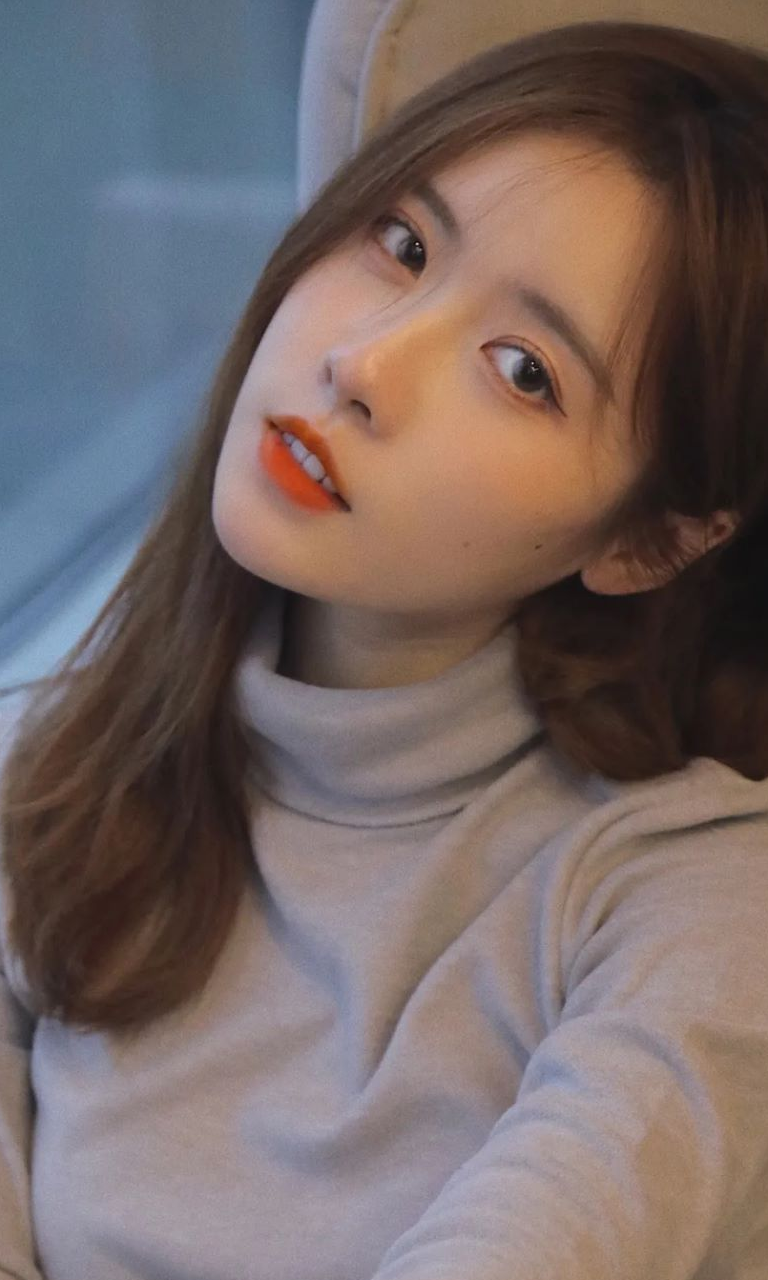

In [14]:
# a["test"][2]["image"]
# a["train"][2]["hint"]
a["train"][2]["image"]


In [74]:
from transformers import AutoTokenizer, PretrainedConfig
from torchvision import transforms
import functools
import diffusers
import torch
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    DDPMScheduler,
    StableDiffusionXLControlNetPipeline,
    UNet2DConditionModel,
    UniPCMultistepScheduler,
)
from datasets.fingerprint import Hasher

pretrained_model_name_or_path='/home/dell/workspace/models/stable-diffusion-xl-base-1.0'
device = "cuda"
revision = None
dtype = torch.float16
crops_coords_top_left_h = 0
crops_coords_top_left_w = 0
# import correct text encoder classes
def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")

tokenizer_one = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer", revision=revision, use_fast=False
)
tokenizer_two = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer_2", revision=revision, use_fast=False
)

text_encoder_cls_one = import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path, revision
)
text_encoder_cls_two = import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path, revision, subfolder="text_encoder_2"
)

text_encoder_one = text_encoder_cls_one.from_pretrained(
    pretrained_model_name_or_path,
    subfolder='text_encoder',
    torch_dtype=dtype,   # -- if it make it un able to update weight 
    revision=revision,
    use_safetensors=True,
    variant='fp16'
)
text_encoder_two = text_encoder_cls_two.from_pretrained(
        pretrained_model_name_or_path,
        subfolder='text_encoder_2',
        torch_dtype=dtype,
        use_safetensors=True,
        variant='fp16'
    )
text_encoders = [text_encoder_one.to(device), text_encoder_two.to(device)]
tokenizers = [tokenizer_one, tokenizer_two]

# Adapted from pipelines.StableDiffusionXLPipeline.encode_prompt
def encode_prompt(prompt_batch, text_encoders, tokenizers, proportion_empty_prompts, is_train=True):
    prompt_embeds_list = []

    captions = []
    for caption in prompt_batch:
        if random.random() < proportion_empty_prompts:
            captions.append("")
        elif isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])

    with torch.no_grad():
        for tokenizer, text_encoder in zip(tokenizers, text_encoders):
            text_inputs = tokenizer(
                captions,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            prompt_embeds = text_encoder(
                text_input_ids.to(text_encoder.device),
                output_hidden_states=True,
            )

            # We are only ALWAYS interested in the pooled output of the final text encoder
            pooled_prompt_embeds = prompt_embeds[0]
            prompt_embeds = prompt_embeds.hidden_states[-2]
            bs_embed, seq_len, _ = prompt_embeds.shape
            prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)
            prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(bs_embed, -1)
    return prompt_embeds, pooled_prompt_embeds

def prepare_train_dataset(dataset, accelerator=None):
    image_transforms = transforms.Compose(
        [
            # transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            # transforms.CenterCrop(args.resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    conditioning_image_transforms = transforms.Compose(
        [
            # transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            # transforms.CenterCrop(args.resolution),
            transforms.ToTensor(),
        ]
    )
    image_column, conditioning_image_column = "image", "hint"
    def preprocess_train(examples):
        images = [image.convert("RGB") for image in examples[image_column]]
        images = [image_transforms(image) for image in images]

        conditioning_images = [image.convert("RGB") for image in examples[conditioning_image_column]]
        conditioning_images = [conditioning_image_transforms(image) for image in conditioning_images]

        examples["pixel_values"] = images
        examples["conditioning_pixel_values"] = conditioning_images
        examples["text"] = examples["text"]
        return examples

    # with accelerator.main_process_first():
    dataset = dataset.with_transform(preprocess_train)

    return dataset

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


In [75]:
train_dataset = prepare_train_dataset(a["train"], None)
test_dataset = prepare_train_dataset(a["test"], None)
print(f">> len train_dataset{len(train_dataset)}, len testdataset {len(test_dataset)}")

>> len train_dataset187, len testdataset 6


In [79]:
import random
def compute_embeddings(batch, proportion_empty_prompts, text_encoders, tokenizers, is_train=True):
    # print(f">> batch keys {batch.keys()}, batch_hint{len(batch['hint'])}")
    # KeysView({'image': [<PIL.ize=768x1280 at 0x7F5DB2AEA470>, ize=768x1280 at 0x7F5DB2AEAB00>], 
    # 'hint': [<PIL size=768x1280 at 0x7F5DB2AEB460>, <Psize=768x1280 at 0x7F5DB2AEADA0>], 'text':
    # sz = batch["hint"][0].size
    sz = batch["hint"][0].size
    original_size = sz
    target_size = sz
    crops_coords_top_left = (0, 0)
    prompt_batch = batch['text']

    prompt_embeds, pooled_prompt_embeds = encode_prompt(
        prompt_batch, text_encoders, tokenizers, proportion_empty_prompts, is_train
    )
    add_text_embeds = pooled_prompt_embeds

    # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    add_time_ids = torch.tensor([add_time_ids])

    prompt_embeds = prompt_embeds.to(device)
    add_text_embeds = add_text_embeds.to(device)
    add_time_ids = add_time_ids.repeat(len(prompt_batch), 1)
    add_time_ids = add_time_ids.to(device, dtype=prompt_embeds.dtype)
    unet_added_cond_kwargs = {"text_embeds": add_text_embeds, "time_ids": add_time_ids}
    # print(f">> unet_added_cond_kwargs keys {unet_added_cond_kwargs.keys()}")
    return {"prompt_embeds": prompt_embeds, **unet_added_cond_kwargs}

compute_embeddings_fn = functools.partial(
    compute_embeddings,
    text_encoders=text_encoders,
    tokenizers=tokenizers,
    proportion_empty_prompts=0.3,
)
new_fingerprint = Hasher.hash(1)
# a["test"].map(            

In [80]:
train_dataset = train_dataset.map(            
            compute_embeddings_fn, 
            batched=True, 
            batch_size=1,
            new_fingerprint=Hasher.hash(1)
        )
print(">> ----------assert train_dataset  contain the embeds", train_dataset[0].keys())


Map: 100%|██████████| 187/187 [00:21<00:00,  8.54 examples/s]


>> ----------assert train_dataset  contain the embeds dict_keys(['image', 'hint', 'text', 'prompt_embeds', 'text_embeds', 'time_ids', 'pixel_values', 'conditioning_pixel_values'])


In [81]:
test_dataset[0].keys()

dict_keys(['image', 'hint', 'text', 'pixel_values', 'conditioning_pixel_values'])

In [82]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    conditioning_pixel_values = torch.stack([example["conditioning_pixel_values"] for example in examples])
    conditioning_pixel_values = conditioning_pixel_values.to(memory_format=torch.contiguous_format).float()

    prompt_ids = torch.stack([torch.tensor(example["prompt_embeds"]) for example in examples])

    add_text_embeds = torch.stack([torch.tensor(example["text_embeds"]) for example in examples])
    add_time_ids = torch.stack([torch.tensor(example["time_ids"]) for example in examples])

    return {
        "pixel_values": pixel_values,
        "conditioning_pixel_values": conditioning_pixel_values,
        "prompt_ids": prompt_ids,
        "unet_added_conditions": {"text_embeds": add_text_embeds, "time_ids": add_time_ids},
    }
# >> ----------assert train_dataset  contain the embeds dict_keys(['hint', 'text', 'prompt_embeds', 'text_embeds', 'time_ids', 'pixel_values', 'conditioning_pixel_values'])
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,  #  
    collate_fn=collate_fn,
    batch_size=1,
    num_workers=4,
)
sz_list_vali = []
for inx, it in enumerate(train_dataloader):
    # print(it.keys())
    sz_list_vali.append(it["pixel_values"].shape)
    # break
    

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [83]:
len(sz_list_vali)

187

In [59]:
# ---- test caption by blip ---------------

img_path = "/home/dell/workspace/dataset/beautygirl/s1.jpeg"
image = Image.open(img_path)
text=""
inputs = processor(image, text, return_tensors="pt")
for k,v in inputs.items():
    inputs[k] = v.to(model.device)
out = model.generate(**inputs)
out_s = processor.decode(out[0], skip_special_tokens=True)
print(f">> {out_s}")

>> araffe woman in a white shirt and blue skirt holding a white purse


debug check if middle crop is corret ~  an is // 8 

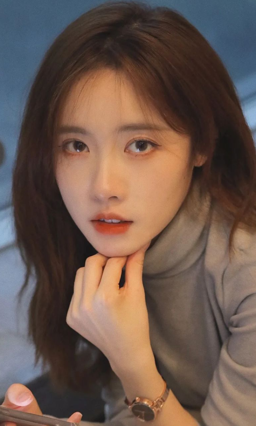

In [7]:
(left, top, right, bottom), (target_width, target_heigt)  = smart_crop(output, target_optional)
crop_img = img.crop((left, top, right, bottom))
# output_copy = output.copy()
# draw = ImageDraw.Draw(output_copy)
# draw.rectangle(bbox, outline='white')
# draw.rectangle((left, top, right, bottom), outline='green')
# output_copy.convert("RGB").resize(size = (output_copy.size[0]//2, output_copy.size[1]//2))
crop_img.resize(size = (crop_img.size[0]//3, crop_img.size[1]//3))

In [76]:
# ~~-- caption image ----~~, 看起来描述非常不准
img = Image.open("../girl100/sc6.jpeg")
# img_path = "/home/dell/workspace/dataset/beautygirl/s1.jpeg"
img_path = "../girl100/sc6.jpeg"
image = Image.open(img_path)
text="describe"
inputs = processor(image, text, return_tensors="pt")
for k,v in inputs.items():
    inputs[k] = v.to(model.device)
out = model.generate(**inputs)
out_s = processor.decode(out[0], skip_special_tokens=True)
print(f">> {out_s}")

>> describe this image of a woman sitting on a couch with a remote


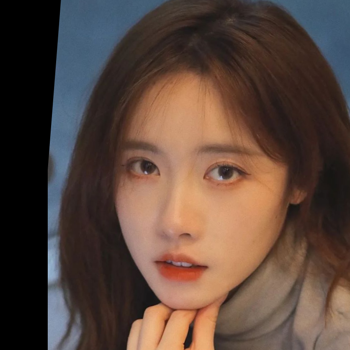

In [20]:
cv2_image = cv2.cvtColor(np.array(crop_img), cv2.COLOR_RGB2BGR)
croped_aligned_face = mp_align_crop_cv2(cv2_image, mp_face_detection)

# cv2.imwrite(new_path_crop, croped_aligned_face)
pil_image = Image.fromarray(cv2.cvtColor(croped_aligned_face, cv2.COLOR_BGR2RGB))
pil_image.resize(size=(350, 350))

In [72]:
# ---- face特征  人脸相似度------
img = Image.open("../girl100/sc6.jpeg")
emb1 = inference(dict(user=pil_image))[OutputKeys.IMG_EMBEDDING]
emb2 = inference(dict(user=a_img))[OutputKeys.IMG_EMBEDDING]
sim = np.dot(emb1[0], emb2[0])
sim
# print(f'Face cosine similarity={sim:.3f}, img1:{img1}  img2:{img2}')

2023-10-25 10:27:37,261 - modelscope - INFO - model inference done
2023-10-25 10:27:37,369 - modelscope - INFO - model inference done


0.9642664

# ✍️ 扣出人脸处理~


In [ ]:
import cv2
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

# faces[0].bbox 
import mediapipe as mp
from alian_face import mp_align_crop
mp_face_detection = mp.solutions.face_detection

# app = FaceAnalysis(name='buffalo_l')
# app.prepare(ctx_id=0, det_size=(640, 640))
# swapper = insightface.model_zoo.get_model('inswapper_128.onnx', download=True, download_zip=True)


In [50]:
p = Path(src)
# 使用 glob 匹配所有文件  #  p.glob('*.py')
files = p.glob('*')
name_shape = []
for file in files:
    src_img = file   #     '/home/dell/workspace/xl_lora/zdxpure/20230921-142228.jpeg'
    # img = Image.open(src_img)
    img = cv2.imread(src_img)  
    print(img.shape)
    break
    # faces = app.get(img)
    # faces = sorted(faces, key = lambda x : x.bbox[0])
    croped_aligned_face = mp_align_crop(src_img, mp_face_detection)
    img_name = src_img.split("/")[-1]  # .replace("jpeg", "png")
    cv2.imwrite(new_path_crop, croped_aligned_face)
    
    
    


NameError: name 'src' is not defined

# 👑 Blip2

In [94]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
blip2_processor = AutoProcessor.from_pretrained("/home/dell/llm/blip2-opt-2.7b/")
blip2_model = Blip2ForConditionalGeneration.from_pretrained("/home/dell/llm/blip2-opt-2.7b/", 
                                                      load_in_8bit=True,  
                                                      torch_dtype=torch.float16)


Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.44s/it]


In [98]:
img_path = "../girl100/sc1.jpeg"
device = "cuda"
image = Image.open(img_path)

prompt = ""

inputs = blip2_processor(images=image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = blip2_model.generate(**inputs)
generated_text = blip2_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


a woman with long hair sitting on a chair


In [ ]:
#  ------ usage ---------
inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

# -------using mulr dialoge -----------
context = [
   ("What is a dinosaur holding?", "a torch"),
   ("Where are they?", "In the woods.")
]
question = "What for?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)





#  😂 试用blip生产图片描述~ 或者用llm多模态生成图片描述~


In [1]:
from PIL import Image
from datasets import load_dataset
from transformers import pipeline
#  -- way ||--
from transformers import BlipProcessor, BlipForConditionalGeneration

# captioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-large", device=0)
# captioner = pipeline("image-to-text",model="/home/dell/llm/blip/", device=0)


blip_processor = BlipProcessor.from_pretrained("/home/dell/llm/blip/")
blip_model = BlipForConditionalGeneration.from_pretrained("/home/dell/llm/blip/").cuda()



/home/dell/.conda/envs/sd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-20 12:03:08.567521: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 12:03:08.619803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# dataset = load_dataset('/home/dell/workspace/T2IAdapter-SDXL-Diffusers/fill50k/fill50kx.py' )
dataset = load_dataset('/home/dell/workspace/T2IAdapter-SDXL/face3w/face3w.py')


In [5]:
import torch
from PIL import Image

@torch.no_grad()
def caption_image_data_by_text(example):
    text="a face of"
    image = example["image"]
    inputs = blip_processor(image, text, return_tensors="pt")
    for k,v in inputs.items():
        inputs[k] = v.to(model.device)
    out = blip_model.generate(**inputs)
    example['image_caption'] =  processor.decode(out[0], skip_special_tokens=True)
    return example

@torch.no_grad()
def caption_image_data(img_path):
    text="a face of"
    # image = open(img_path, "rb").read()
    image = Image.open(img_path)
    inputs = blip_processor(image, text, return_tensors="pt")
    for k,v in inputs.items():
        inputs[k] = v.to(model.device)
    out = blip_model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)
    # return example

In [8]:
res = dataset["test"].map(caption_image_data_by_text)
res["image_caption"]

['a face of a man with glasses and a tie',
 'a face of a man with a black hoodie and a blue light',
 'a face of a man with a gray shirt and a tie',
 'a face of a man with a jacket on and a white shirt',
 'a face of a man with glasses and a black jacket',
 'a face of a man with a backpack and a tie']

In [11]:
img_path = "/home/dell/workspace/dataset/beautygirl/s1.jpeg"
image = Image.open(img_path)
text=""
inputs = blip_processor(image, text, return_tensors="pt")
for k,v in inputs.items():
    inputs[k] = v.to(model.device)
out = blip_model.generate(**inputs)
out_s = blip_processor.decode(out[0], skip_special_tokens=True)
print(f">> {text} {out_s}")

>>  araffe woman in a white shirt and blue skirt holding a white purse


In [15]:
img_path = "/home/dell/workspace/dataset/beautygirl/s1.jpeg"
image = Image.open(img_path)
text="what view , what lens"
inputs = processor(image, text, return_tensors="pt")
for k,v in inputs.items():
    inputs[k] = v.to(model.device)
out = model.generate(**inputs)
out_s = processor.decode(out[0], skip_special_tokens=True)
print(f">> {out_s}")

>> what view, what lens, what picture, what picture, what picture, what picture, what


# 👒👒 webui tagger 产生tag
-  目前来看需要用caption来完善

In [77]:
from tagger_webui import load_model, load_labels, parse_args, MOAT_MODEL_REPO, MODEL_FILENAME, predict, predictv2
from argparse import Namespace
import functools
from PIL import Image

In [82]:
examples=[["../girl100/sc1.jpeg", "MOAT", 0.35, 0.85]]
global loaded_models
loaded_models = {
    "MOAT": None,    "SwinV2": None,    "ConvNext": None,    "ConvNextV2": None,    "ViT": None,
}
loaded_models[examples[0][1]] = load_model(MOAT_MODEL_REPO, MODEL_FILENAME)

tag_names, rating_indexes, general_indexes, character_indexes = load_labels()
print(f">>, tag_names {len(tag_names)}, rating_indexes {len(rating_indexes)} ,\
        general_indexes {len(general_indexes)}, character_indexes {len(character_indexes)}")

func = functools.partial(
    predictv2,
    tag_names=tag_names,
    rating_indexes=rating_indexes,
    general_indexes=general_indexes,
    character_indexes=character_indexes,
)


>> load model :/home/dell/workspace/dataset/caption/wd-v14-moat-tagger-v2/model.onnx
>>, tag_names 9083, rating_indexes 4 ,        general_indexes 6947, character_indexes 2132


2023-10-25 11:55:05.769593232 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:614 CreateExecutionProviderInstance] Failed to create TensorrtExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/TensorRT-ExecutionProvider.html#requirements to ensure all dependencies are met.
2023-10-25 11:55:05.769613644 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:640 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Please reference https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements to ensure all dependencies are met.


In [100]:
img = Image.open(examples[0][0])
model_name = loaded_models[examples[0][1]]
general_threshold = 0.35
character_threshold = 0.85
res = func(img, model_name, general_threshold, character_threshold)
raw_text,cates, rating, character_res, general_res, info = res
raw_text

'1girl, solo, watch, brown hair, looking at viewer, long hair, wristwatch, realistic, parted lips, teeth, outdoors, holding, brown eyes, sitting, lips, long sleeves, phone, hand on own chin, day'


# 💕 apply fun to dataset~

In [59]:
import jsonlines as jsl
import pandas as pd

metadata_path = "/home/dell/workspace/T2IAdapter-SDXL-Diffusers/face3w/test.jsonl"

targe_dir = "face3w/"

ds = jsl.open(metadata_path)

metadata = pd.read_json(metadata_path, lines=True)


In [60]:
metadata["text"] = metadata["image"].apply(lambda x: caption_image_data(targe_dir + x))

/home/dell/.conda/envs/sd/lib/python3.8/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [63]:
# cond_path_ = targe_dir + ""
metadata.to_json(metadata_path, orient='records', lines=True)